In [31]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# Image inpainting with proximal methods - 30 points

Image in-painting consists of reconstructing the missing parts of an image from a given incomplete image.

By exploiting some prior knowledge on the image, it is possible to in-paint images that have a large portion of their pixels missing. In this part of the homework, we are going to study different methods to achieve this goal.

We consider a subsampled image $\mathbf{b} = \mathbf{P}_{\Omega} \mathbf{x}$, where $\mathbf{P}_{\Omega} \in \mathbb{R}^{n \times p}$ is an operator that selects only few, $n \ll p := m^2$, pixels from the vectorized image $\mathbf{x} \in \mathbb{R}^p$. Our goal is to reconstruct the original image $\mathbf{x}$.

### Prior knowledge

Image inpainting is impossible without having some prior knowledge on the structure of the true image $\mathbf{x}$. 

We will explore and compare the following prior assumptions we can make on the true image: 
>  **Assumption**: There exists a orthonormal basis $\mathbf{W} \in \mathbb{R}^{p\times p}$ such that $\mathbf{x}$ can be sparsely represented in that basis, i.e, $\mathbf{W} \mathbf{x}$ is a vector with few non-zero coefficients. Said more formally, this assumption states that there exists $\mathbf{\alpha} \in \mathbb{R}^p$ with small $\ell_1$ norm such that $\mathbf{x} = \mathbf{W}^\top\alpha$. We assume that this basis is known and corresponds to the _wavelet basis_. Under this assumption, the reconstruction problem corresponds to solving the following optimization problem:
$$
    \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2}_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
$$
where $\lambda_{\ell_1}$ is a coefficient we will need to choose.



# PART 1: Optimizing with an $\ell_1$ norm regularization

The optimization problem we are looking to solve have an objective function of the form:
$$
	 f(\mathbf{x}) + g(\mathbf{x}).
$$

These types of objectives are referred to as _composite objectives_ where one term, $f$, is smooth and differentiable and the other term $g$ is non-differentiable.

---

## Code structure:

Recall that we have been working with the `Function` type so far. We will augment this type to represent functions that are not differentiable:

- Given a `Function` `g` you can obtain a subgradient at a point `x` by calling `g.subgrad(x)`.

Moreover, since we are dealing with _composite_ problems with a an objective function that can be written `f + lambda*g`, we define the `CompositeFunction` type defined as
```python
@dataclass
class CompositeFunction:
    f: Function
    g: Function
```

The iterative schemes you will implement will receive a composite function that they can unpack as follows:

```python
def state_update(composite_function, state):
    f, g = composite_function

```

#### Question 1: (5 point)

A first approach to solve a non-smooth optimization problem can be to turn to subgradients. Review slide 42-44 of Lecture 6, and implement `SubG` with $\alpha_k = \frac{0.1}{\sqrt{k}}$.

In [32]:
@dataclass
class SubG_state(OptState):
    x_k: Vector
    k: int

In [33]:
def SubG_update(composite_function, state):
    f, g, = composite_function
    x_k = state.x_k
    k = state.k

    grad_f = f.grad(x_k)
    subgrad_g = g.subgrad(x_k)
    tot_subgrad = grad_f + subgrad_g

    alpha_k = 0.1/np.sqrt(k)
    return SubG_state(x_k = x_k - alpha_k*tot_subgrad, k = k+1)


def SubG_initialize(composite_function, x_zero):
    x_k = x_zero 
    k = 1 
    return SubG_state(x_k, k)

In [34]:
SubG = OptAlgorithm(name="SubG", init_state=SubG_initialize, state_update=SubG_update)

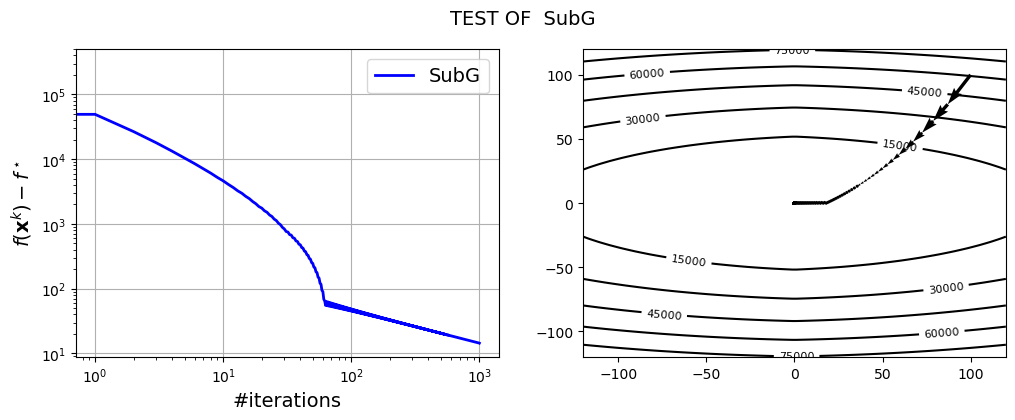

In [35]:
test_composite(SubG)


---

Another, more efficient approach, as we saw in Lecture 7, is to minimize such a function by using proximal gradient algorithms, provided that $g$ is _proximable_ (i.e., its proximal operator is efficient to evaluate). We recall the proximal operator of $g$ as the solution to the following convex problem:
$$
\mathrm{prox}_g(\mathbf{z}) := \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ g(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}.
$$

#### Question 2 (2 points)

Given $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,  show that its proximal function can be written as
    $$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
    $$
			where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$. Such a regularizer imposes sparsity on the solutions.


To show that the proximal function of $g_{\ell_1}$ can be written as $ \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z})$, we need to solve the following optimization problem:

$$
\mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \mathrm{arg}\min_{\mathbf{x}\in\mathbb{R}^p}\{ g_{\ell_1}(\mathbf{x}) + \frac{1}{2}\Vert\mathbf{x} - \mathbf{z}\Vert_2^2\}
$$

Given $g_{\ell_1}(\mathbf{x}) = \|\mathbf{x}\|_1$, the optimization problem becomes:

$$
\mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \mathrm{arg}\min_{\mathbf{x}\in\mathbb{R}^p}\{ \gamma \|\mathbf{x}\|_1 + \frac{1}{2}\Vert\mathbf{x} - \mathbf{z}\Vert_2^2\}
$$

This can be solved coordinate-wise. For each coordinate $x_i$ of $ \mathbf{x} $, we need to solve:

$$
\min_{x_i} \left\{ \gamma |x_i| + \frac{1}{2}(x_i - z_i)^2 \right\}
$$

To solve this, we consider two cases: $x_i \geq 0$ and $x_i < 0$.

1. **Case 1: $x_i \geq 0$**

    The optimization problem becomes:

    $$
    \min_{x_i \geq 0} \left\{ \gamma x_i + \frac{1}{2}(x_i - z_i)^2 \right\}
    $$

    Taking the derivative and setting it to zero:

    $$
    \gamma + (x_i - z_i) = 0 \implies x_i = z_i - \gamma
    $$

    Since $x_i \geq 0$, we have:

    $$
    x_i = \max(z_i - \gamma, 0)
    $$

2. **Case 2: $y_i < 0$**

    The optimization problem becomes:

    $$
    \min_{x_i < 0} \left\{ -\gamma x_i + \frac{1}{2}(x_i - z_i)^2 \right\}
    $$

    Taking the derivative and setting it to zero:

    $$
    -\gamma + (x_i - z_i) = 0 \implies x_i = z_i + \gamma
    $$

    Since $x_i < 0$, we have:

    $$
    x_i = \min(z_i + \gamma, 0)
    $$

Combining both cases, we get:

$$
\mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}| - \gamma, 0) \circ \mathrm{sign}(\mathbf{z})
$$



#### Question 3 (1 point)
 Fill in the function `l1_prox` with the proximal operator of $g_{\ell_1}$.

In [36]:
def l1_prox(gamma, z):
    return np.sign(z) * np.maximum(np.abs(z) - gamma, 0)

#### Question 4 (4 points)

From here on, in order to speed-up the convergence of the optimization, let's assume that the function $f$ has been made to be $\mu$-strongly convex by the addition of an $\ell_2$ regularization term to the function $f$, while the $\ell_1$ term, $g$, has remained unchanged. As such, we must now utilize the strong-convexity versions of the composite optimization algorithms.

Using the information in Lecture 7 slide 21 fill in the codes of the method ISTA$_{\mu}$.

In [37]:
@dataclass
class ISTA_state(OptState):
    x_k: Vector
    alpha_k: float

In [38]:
def ISTA_update(composite_function, state):
    f, g = composite_function
    x_k = state.x_k
    alpha_k = state.alpha_k

    grad_f = f.grad(x_k)
    x_k_1= l1_prox(alpha_k, x_k - alpha_k*grad_f)

    return ISTA_state(x_k = x_k_1, alpha_k = alpha_k)

def ISTA_initialize(composite_function, x_zero):
    x_k = x_zero
    f, g = composite_function
    alpha_k = 2/(f.lips_grad + f.strng_cvx)
    
    return ISTA_state(x_k, alpha_k)

In [39]:
ISTA = OptAlgorithm(name="ISTA", init_state= ISTA_initialize, state_update=ISTA_update)

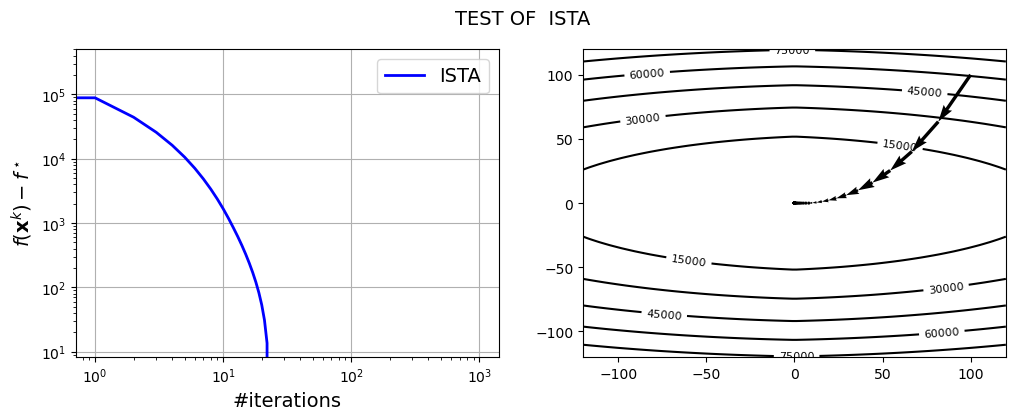

In [40]:
test_composite(ISTA)

#### Question 5  (7 points)

Using the information in Lecture 7 slide 21 fill in the codes of the method FISTA$_{\mu}$.

In [41]:
@dataclass 
class FISTA_state(OptState):
    x_k: Vector
    y_k: Vector
    alpha_k: float
    c_f : float

In [42]:
import numpy

def FISTA_update(composite_function, state):
    f, g = composite_function
    x_k = state.x_k
    y_k = state.y_k
    alpha_k = state.alpha_k
    c_f = state.c_f

    grad_f = f.grad(y_k)
    x_k_1= l1_prox(alpha_k, y_k - alpha_k*grad_f)
    y_k_1 = x_k_1 + (np.sqrt(c_f) - 1)/(np.sqrt(c_f) + 1)*(x_k_1 - x_k)

    return FISTA_state(x_k = x_k_1, y_k = y_k_1, alpha_k = alpha_k, c_f = c_f)

def FISTA_initialize(composite_function, x_zero):
    f, g = composite_function
    x_k = x_zero
    y_k = x_zero
    alpha_k = 1/f.lips_grad
    c_f = f.lips_grad/f.strng_cvx
    return FISTA_state(x_k, y_k, alpha_k, c_f)


In [43]:
FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

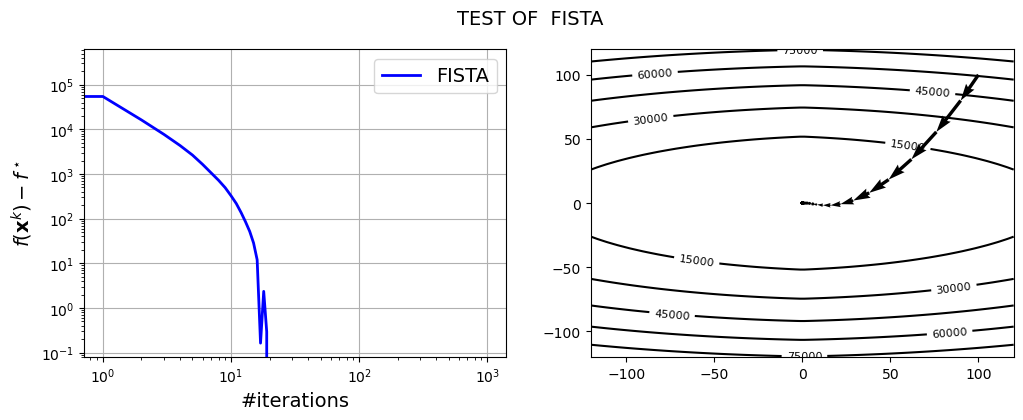

In [44]:
test_composite(FISTA)

#### Question 6  (2 points)

Compare the convergence rates of the three methods and analyze whether the observed results align with their theoretical bounds.

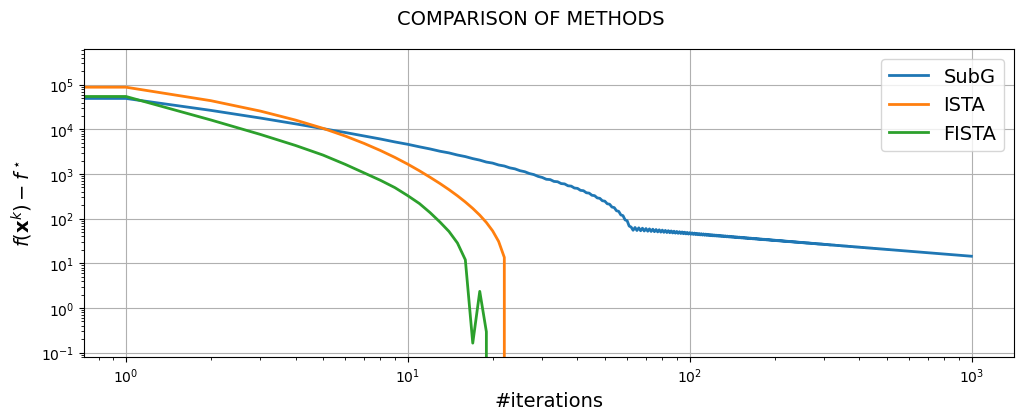

In [45]:
list_of_methods = [SubG, ISTA, FISTA]
compare_composite(list_of_methods)


The theoretical convergence rates for these methods are as follows:
- **SubG**: Subgradient methods typically have a convergence rate of $(O(1/\sqrt{k})$ for non-smooth optimization problems.
- **ISTA**: The Iterative Shrinkage-Thresholding Algorithm (ISTA) has a convergence rate of $O(1/k)$ for smooth and strongly convex problems.
- **FISTA**: The Fast Iterative Shrinkage-Thresholding Algorithm (FISTA) improves upon ISTA with a convergence rate of $O(1/k^2)$.



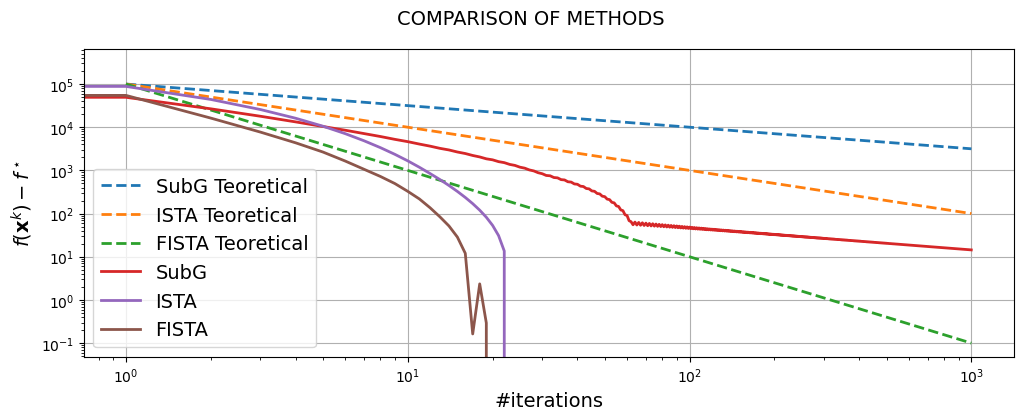

In [46]:
def compare_composite2(methods):
    M = np.diag(np.arange(1, 11))
    f = Function(f=lambda u: 0.5*np.dot(u, np.dot(M, u)), grad=lambda u: np.dot(M, u), minimum=0.0, lips_grad=10.0, strng_cvx=1.0)
    g = Function(f=lambda x: 30*np.sum(np.abs(x), axis=0), subgrad= lambda x: 30*np.sign(x), prox=lambda gamma, x: np.sign(x)*np.maximum(np.abs(x) - 30*gamma, 0.0))
    composite_function = CompositeFunction(f = f, g=g, minimum=0.0)
    maxiter = 1000
    k = np.arange(1, maxiter+1)
    f, (ax_1) = plt.subplots(1, 1, figsize=(12, 4))
    SubG_tb  = 100000/np.sqrt(k) 
    ISTA_tb = 100000/k
    FISTA_tb = 100000/k**2
    ax_1.plot(k, SubG_tb,"--" ,label="SubG Teoretical", lw=2)
    ax_1.plot(k, ISTA_tb,"--" ,label="ISTA Teoretical", lw=2)
    ax_1.plot(k, FISTA_tb,"--" ,label="FISTA Teoretical", lw=2)
    for method in methods:
        x_zero = 100 * np.ones(10)
        run_trace = run(method, composite_function, x_zero, maxiter)
        
        f.suptitle("COMPARISON OF METHODS ", fontsize=14)

        ax_1.plot(
                range(maxiter),
                np.array(run_trace.values) - composite_function.minimum,
                lw=2,
                label=method.name,
            )
        
            
    ax_1.legend(fontsize=14)
    ax_1.set_xlabel("#iterations", fontsize=14)
    ax_1.set_ylabel("")
    ax_1.set_ylabel(r"$f(\mathbf{x}^k) - f^\star$", fontsize=14)
    ax_1.set_xscale("log")
    ax_1.set_yscale("log")
    ax_1.grid()

    plt.show()

compare_composite2(list_of_methods)


# Part 2: Application


We have now implemented multiple methods that can solve composite optimization problems. We will now apply them to an image inpainting problem.


Take a natural image, or better a picture of you, and place it in the same directory as this notebook.

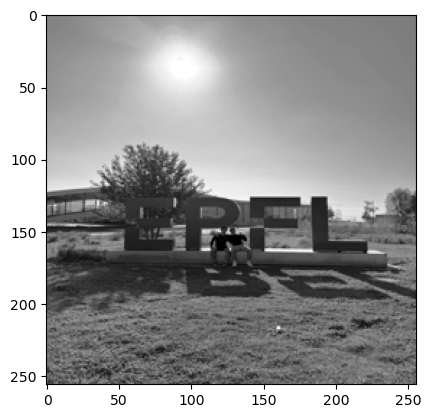

In [58]:
from lib.inpainting import *

image = load("lib/EPFL_pic.jpg") #FILL IN FILE NAME

With this image in hand, let us subsample it and try to reconstruct the original.

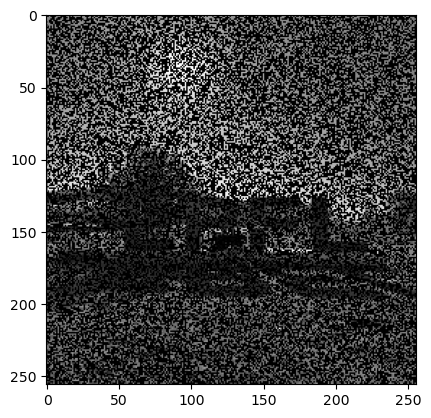

In [48]:
subsampled = show_subsampled(image)

In the following cells we will define the optimization problems we need to solve to perform the reconstruction.

- We provide you with a function `P` that acts like the matrix $\mathbf{P}_{\Omega}$. That is, given a vector `x`, it returns a subsampled vector `P(x)` that corresponds to $\mathbf{P}_{\Omega} \mathbf{x}$. We also give you `P_T` which acts like $\mathbf{P}^\top$.
- We provide you with a function `W` and `W_T` that act like the matrix $\mathbf{W}$ and $\mathbf{W^\top}$ respectively. That is, for a vector `x`, `W(x)` and `W_T(x)` return $\mathbf{W}\mathbf{x}$ and $\mathbf{W^\top}\mathbf{x}$ respectively.

__(a)__ (1 point) Using these provided functions, define the observed variable `b` in the cell below.

In [49]:
from lib.inpainting import P, P_T, W, W_T

x = image.reshape(-1) #flattened image

b =  P(x)

__(b)__ (1 point) Now define the function `f_l1` as described earlier in the problem text.

In [50]:
mu = 0.01 # Desired strong convexity of f
def f_l1(alpha):
    return 0.5 * np.linalg.norm(b - P(W_T(alpha))) ** 2


__(c)__ (1 point) Write the gradient of $f_{\ell_1}(\mathbf{\alpha})$.

In [51]:
def grad_f_l1(alpha):
    return W(P_T((P(W_T(alpha)) - b)))

__(d)__ (1 points) Find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically and fill it in the cell below. 

To find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically, we need to consider the gradient of the smooth part of the objective function. 

Given:
$$
f_{\ell_1}(\mathbf{\alpha}) = \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2
$$

The gradient is:
$$
\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha}) = \mathbf{W} \mathbf{P}_{\Omega}^T (\mathbf{P}_{\Omega} \mathbf{W}^T \mathbf{\alpha} - \mathbf{b})
$$

The Lipschitz constant $L$ of the gradient $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ is given by the largest eigenvalue of the Hessian matrix of $f_{\ell_1}(\mathbf{\alpha})$. For our function, the Hessian is:
$$
\nabla^2 f_{\ell_1}(\mathbf{\alpha}) = \mathbf{W} \mathbf{P}_{\Omega}^T \mathbf{P}_{\Omega} \mathbf{W}^T
$$

The Lipschitz constant $L$ is the largest eigenvalue of $\mathbf{W} \mathbf{P}_{\Omega}^T \mathbf{P}_{\Omega} \mathbf{W}^T$. 

Since $\mathbf{W}$ is an orthonormal basis, $\mathbf{W}^T \mathbf{W} = \mathbf{I}$ and $\mathbf{P}_{\Omega}^T \mathbf{P}_{\Omega}$ is a diagonal matrix with ones at the positions corresponding to the observed pixels and zeros elsewhere, the Lipschitz constant can be simplified to the largest eigenvalue of $\mathbf{P}_{\Omega}^T \mathbf{P}_{\Omega}$, which is 1.

Therefore, the Lipschitz constant $L$ is:
$$
L = 1
$$


In [52]:
lips_grad_f_l1 = 1

We have all the necessary ingredients to define the smooth part of our composite objective:

In [53]:
f_l1 = Function(f = f_l1, grad=grad_f_l1, lips_grad = lips_grad_f_l1, strng_cvx=mu)

For the non-smooth term, we define a regularizer built around the `l1` function that re-uses the `l1_prox` function you implemented earlier:

In [54]:
l1 = Function(f = lambda x: np.sum(np.abs(x), axis=0), prox=l1_prox)

g_l1 = Regularizer(l1)

In [55]:
composite_objective = CompositeFunction(f=f_l1, g=g_l1)


With the objective defined, we provide you with a function with the following signature:
```python
solve_composite(method: OptAlgorithm, composite_objective: CompositeFunction, lmda: float, max_iterations: int) -> Vector
```

In other words, the function takes an optimization algorithm `method`, a CompositeFunction `composite_objective`, a regularization parameter `lmda` and a number of iterations `max_iterations` and returns a vector which is the last iterate given by the `method`.



In [56]:
from lib.inpainting import solve_composite

__(e)__ (5 points) Using `solve_composite` reconstruct the subsampled image. Recall that the composite problem solves for $\mathbf{\alpha}$ so you need to convert the output back to an image and visualize it.

Select a reasonable value for `lmda` or (BONUS) using the function `solve_composite` and the `PSNR` metric, find the best value for `lmda`.

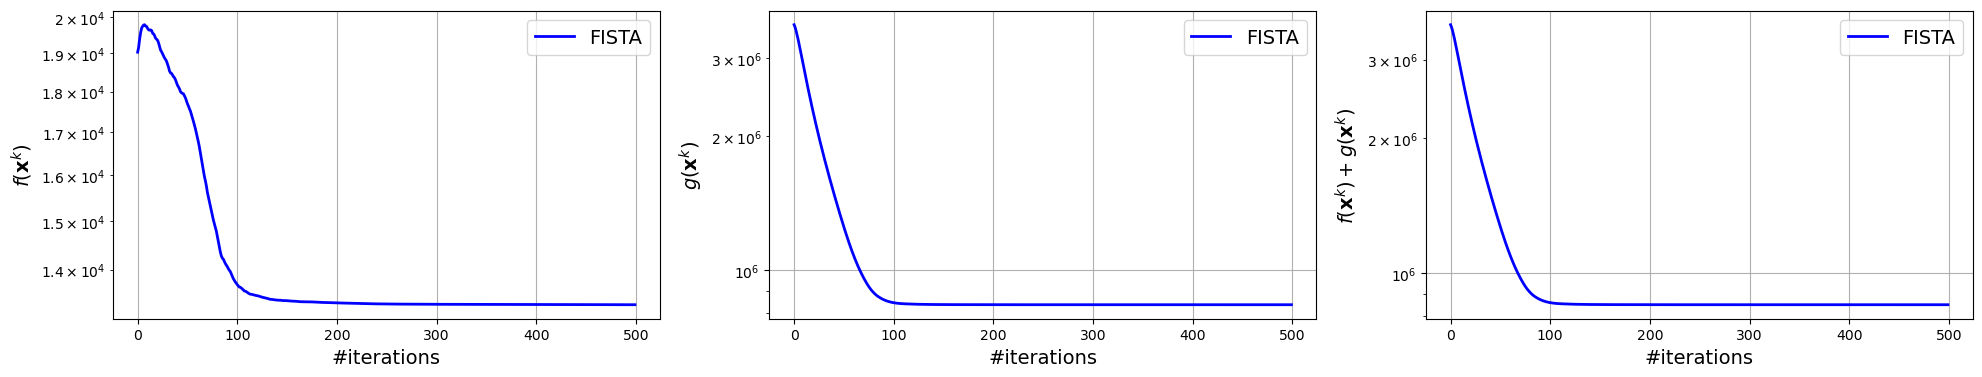

In [57]:
output = solve_composite(FISTA, composite_objective, 1, 500)
flat_image_out = W_T(output)
image_out = flat_image_out.reshape(image.shape)


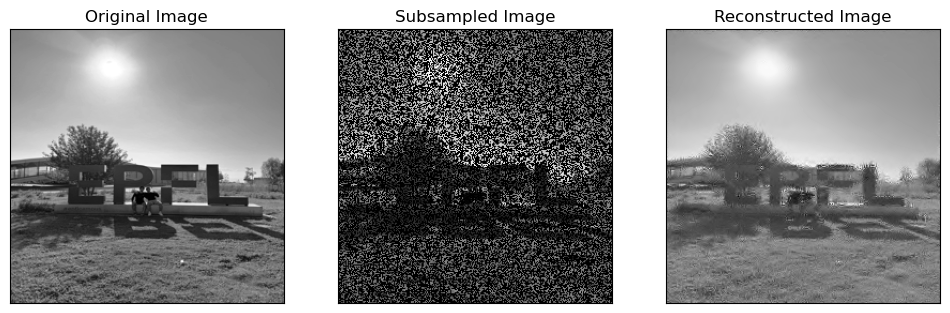

In [35]:
show(true = image, subsampled=subsampled, estimated=image_out)